In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os, gc


BATCH_SIZE = 16        # reduced from 32 → saves RAM
IMAGE_SIZE = 180       # reduced from 256 → saves RAM
CHANNELS = 3
EPOCHS = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tea_Leaf_Disease",  # <-- IMPORTANT: Change this path
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5907 files belonging to 6 classes.


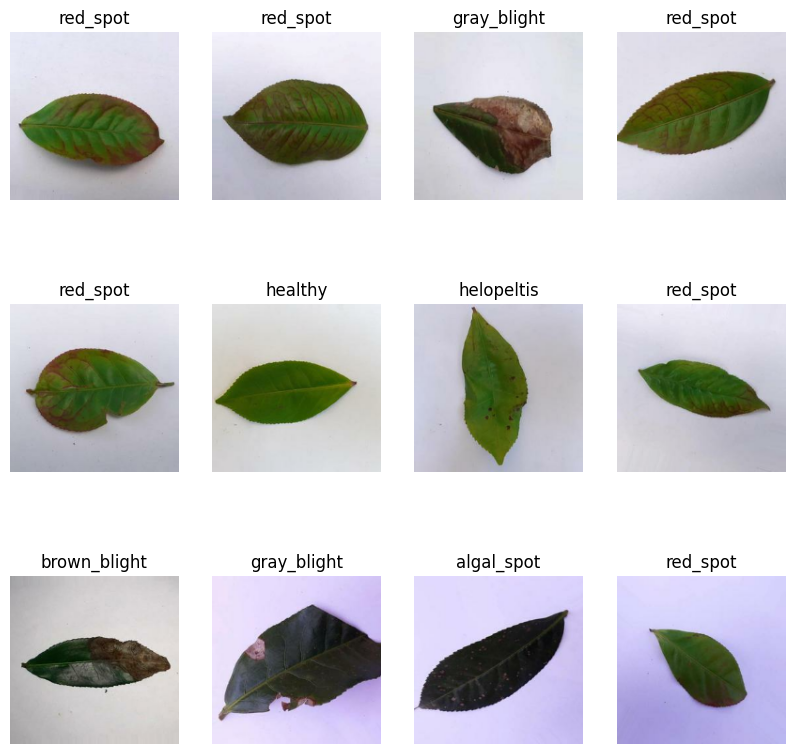

In [4]:
import matplotlib.pyplot as plt

class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [6]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


resize_and_rescale = tf.keras.Sequential([
	tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	tf.keras.layers.Rescaling(1./255),
])

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'), # <--- REMOVE
#     layers.MaxPooling2D((2, 2)),              # <--- REMOVE
#     layers.Conv2D(64, (3, 3), activation='relu'), # <--- REMOVE
#     layers.MaxPooling2D((2, 2)),              # <--- REMOVE
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),
# ])

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (16, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 87, 87, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 43, 43, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 41, 41, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 9, 9, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 5184)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,478 (1.62 MB)

 Trainable params: 425,478 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [10]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 1892s 70ms/step - accuracy: 0.3196 - loss: 1.5220 - val_accuracy: 0.4544 - val_loss: 1.2444
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.5045 - loss: 1.1844 - val_accuracy: 0.5302 - val_loss: 1.1233
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.5505 - loss: 1.0831 - val_accuracy: 0.6858 - val_loss: 0.7681
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.6517 - loss: 0.8633 - val_accuracy: 0.7078 - val_loss: 0.7064
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.6914 - loss: 0.7418 - val_accuracy: 0.7297 - val_loss: 0.6607
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.7091 - loss: 0.6963 - val_accuracy: 0.7128 - val_loss: 0.6434
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.7525 - loss: 0.6282 - val_accuracy: 0.7973 - val_loss: 0.5772
Epoch 8/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.7515 - loss: 0.6267 

In [11]:
scores = model.evaluate(test_ds)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy: {scores[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9438 - loss: 0.2076
Test Loss: 0.18355311453342438
Test Accuracy: 0.9442567825317383


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


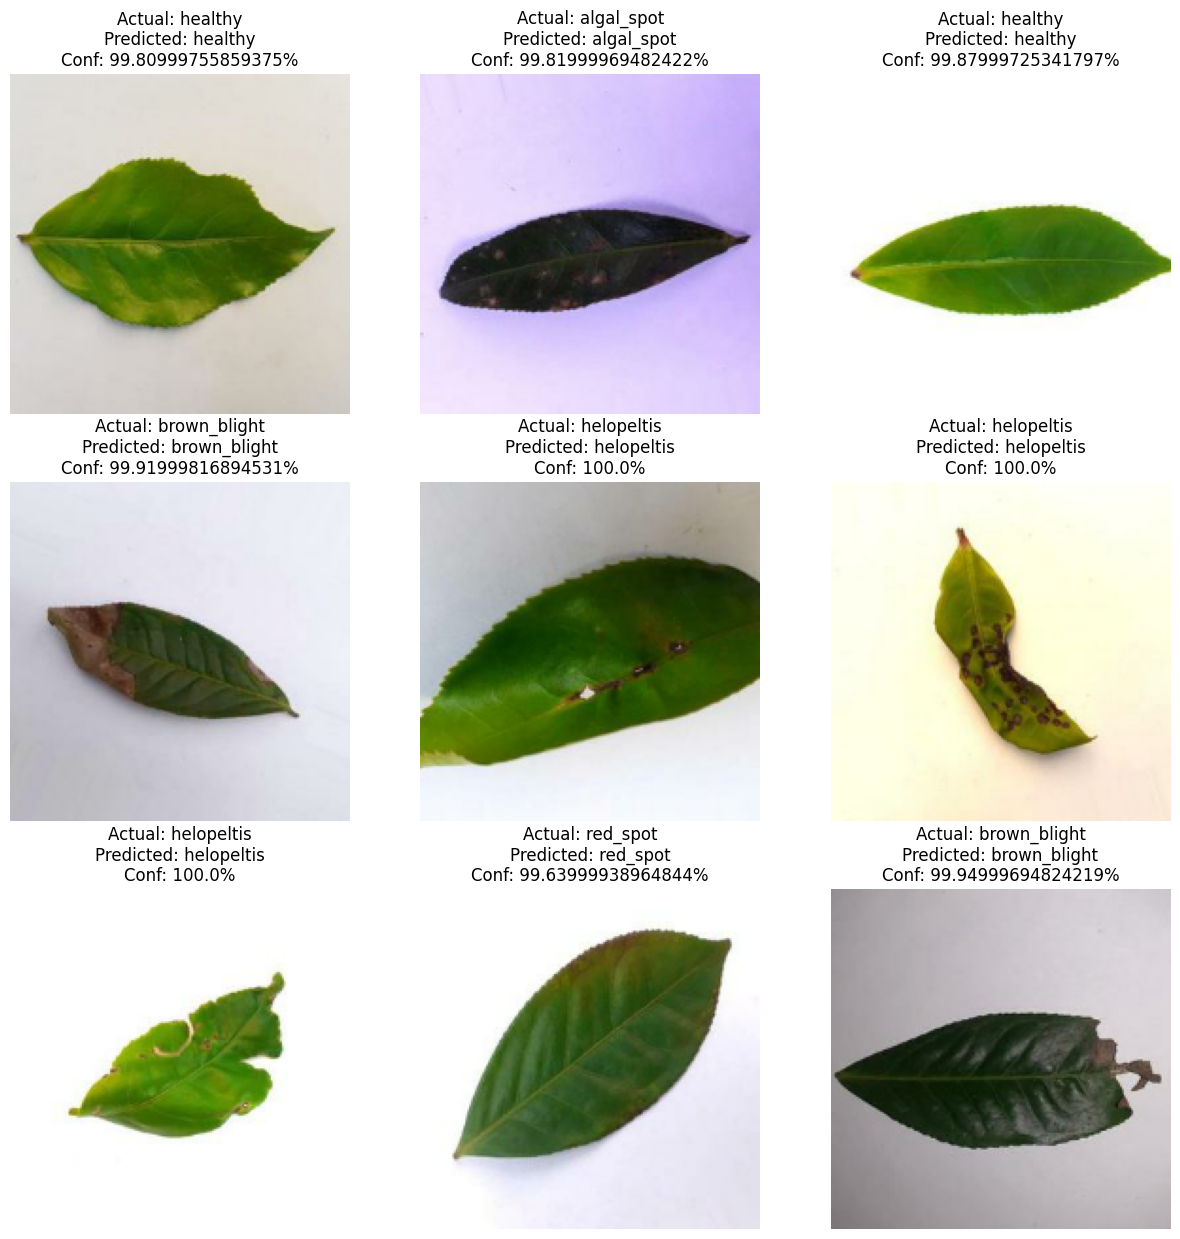

In [12]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # add batch dim
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConf: {confidence}%")
        plt.axis("off")

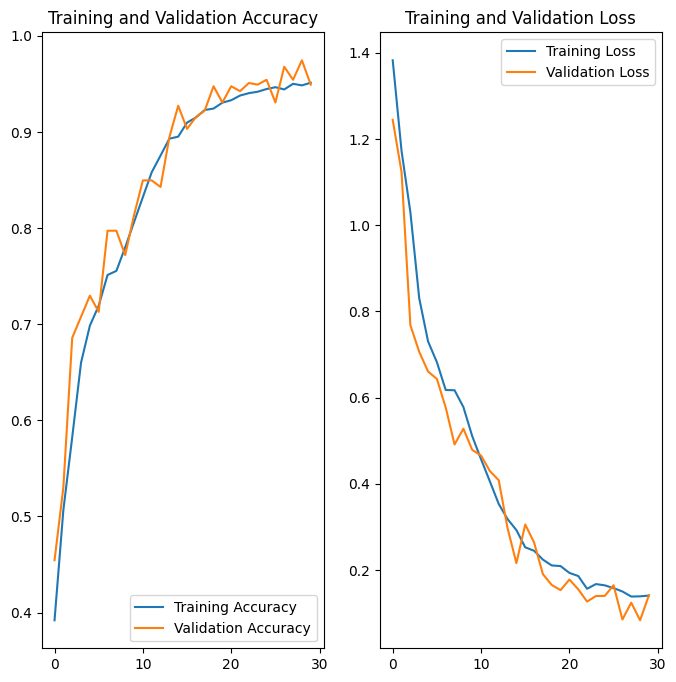

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
import os

# Define the full path to your model file
save_path = '/content/drive/MyDrive/Colab_Models/my_keras_model.keras'

# Extract the directory path from the full file path
directory = os.path.dirname(save_path)

# Create the directory if it doesn't exist
# The 'exist_ok=True' argument prevents an error if the folder already exists
os.makedirs(directory, exist_ok=True)

# Now, you can safely save the model
model.save(save_path)

print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/Colab_Models/my_keras_model.keras
